In [15]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
from interval_bounds import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def gen_synthetic_multinomial(n0,n1,q,r,j):
    # n0,n1 is the number of samples from class 0, 1 resp.
    # q,r is are the theta^+/-
    
    X_train = []
    y_train = []
    
    X_train.extend(np.random.multinomial(j, q, size=n0))
    y_train.extend([1]*n0)
    
    X_train.extend(np.random.multinomial(j, r, size=n1))
    y_train.extend([-1]*n1)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    return X_train, y_train

def gen_synthetic_normal(n,d,sigma):
    
    X = np.random.normal(0, 1, n*d).reshape(n, d)
    w = np.random.normal(0, 1, d)
    y = X@w + np.random.normal(0, sigma, n)
    
    return X, np.array([y]).T, np.array([w]).T

## Create dataset

In [24]:
n = 100 # number of data points
m = 10 # number of features
sigma = 0.1
lamb = 10
rho = 1
X, y, w = gen_synthetic_normal(n,m,sigma)

In [25]:
U_upper, U_lower = find_interval_bounds_infty_uncertainty(X, rho)

In [44]:
l = lambda X: np.linalg.norm(X@np.linalg.pinv(X)@y-y)**2

In [45]:
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of w: ", w.shape)

Shape of X:  (100, 1)
Shape of y:  (100, 1)
Shape of w:  (1, 1)


## Nominal Problem

In [46]:
def solve_nominal(X, y, lamb=10):
    w = cp.Variable((m,1))
    nominal_obj = cp.Minimize(cp.square(cp.norm(X@w - y, 2)) + lamb*cp.square(cp.norm(w,2)))
    constraints = []
    prob = cp.Problem(nominal_obj, constraints)
    prob.solve()
    return prob.value, w.value

In [47]:
loss, w_hat = solve_nominal(X,y,lamb=10)

In [48]:
print("Loss: ", loss)
print(l(X))

Loss:  6.421642582792176
1.0672082223705812


## Robust Problem

In [49]:
def solve_robust(X,y, rho, lambda_):
    # data, labels = X,y
    n,d = X.shape
    w_rob = cp.Variable((d,1))

    abs_resids = cp.abs(X@w_rob - y)
    robper = rho*cp.norm(w_rob, p=2)*np.ones((n,1))
    ridge_pen = lambda_*cp.norm(w_rob, p=2)**2
    obj = cp.norm(abs_resids + robper, p=2)**2 + ridge_pen

    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    return prob.value, w_rob.value

In [50]:
loss, w_hat = solve_robust(X,y,rho=rho,lambda_=lamb)

In [51]:
print("Loss: ", loss)

Loss:  51.362376617020885


## Poisoned Problem

In [1]:
def solve_poisoned(X_nominal, y, lamb=10, rho=10, mu=10):
    X = cp.Variable((n,m))
    M = cp.Variable((m+1,m+1), PSD=True)
    N = cp.Variable((m+n,m+n), PSD=True)
    t = cp.Variable(1)
    U = cp.Variable((m,m), PSD=True)
    poisoned_obj = cp.Minimize(t - cp.square(cp.norm(y)) + mu*cp.trace(U))
    constraints = [
        M[0:m,0:m] == U - lamb*np.eye(m),
        M[m,m] == t,
        M[m:m+1,0:m] == y.T@X,
        M[0:m,m:m+1] == X.T@y,
        N[0:m,0:m] == U,
        N[m:,m:] == np.eye(n),
        N[m:,0:m] == X,
        N[0:m,m:] == X.T,
    ]
    for i in range(n):
        constraints.append(cp.norm(X[i]-X_nominal[i],2) <= rho)
    prob = cp.Problem(poisoned_obj, constraints)
    prob.solve()
    return -1*prob.value, X.value, U.value

In [53]:
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of w: ", w.shape)

Shape of X:  (100, 1)
Shape of y:  (100, 1)
Shape of w:  (1, 1)


In [54]:
print((y.T@X).shape)
print((np.ones((m+1,m+1))[m:m+1,0:m]).shape)

(1, 1)
(1, 1)


In [55]:
X_hats = []
losses = []

In [63]:
for rho in [0.1,0.5,1,5,10]:
    _, X_hat, _ = solve_poisoned(X,y,lamb=lamb,rho=rho,mu=10)
    X_hats.append(X_hat)
    losses.append(l(X_hat))

In [64]:
print(losses)

[1.532058356377373, 15.208258381788959, 47.30517964619165, 53.80235227487822, 53.80235227487822, 1.2012744639618007, 7.385825331078105, 37.25103956260261, 53.80235227487822, 53.80235227487822]


In [65]:
print(X.shape)

(100, 1)


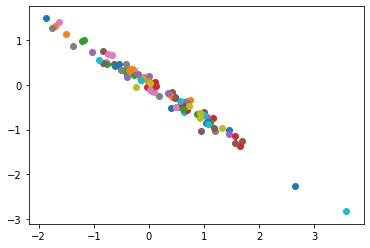

In [66]:
plt.figure()
for i in range(X.shape[0]):
    plt.scatter(X[i],y[i])

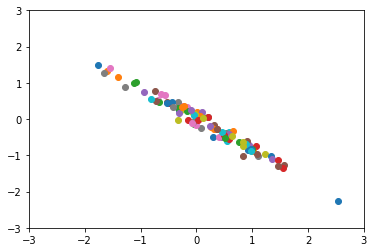

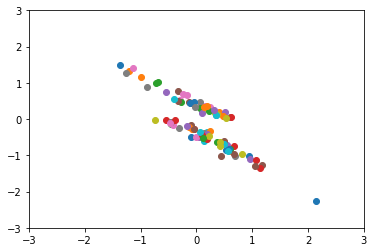

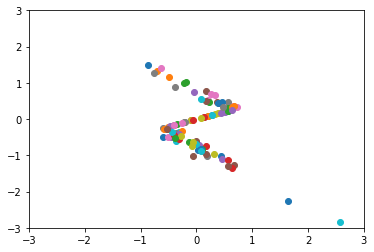

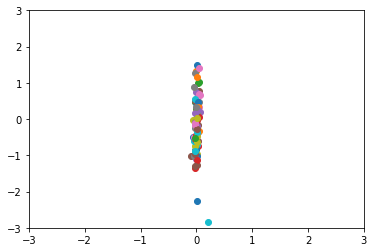

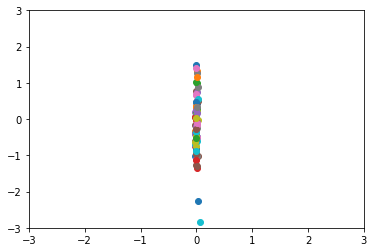

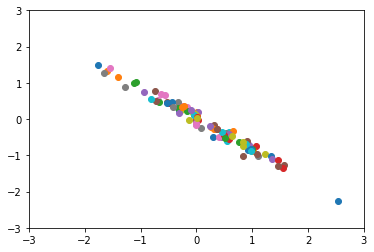

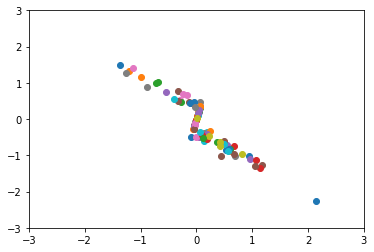

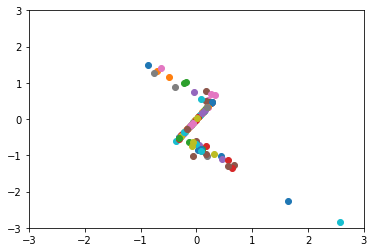

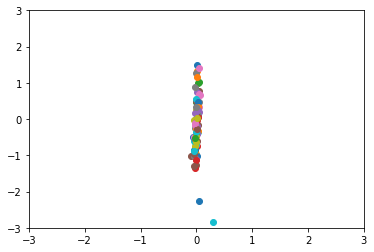

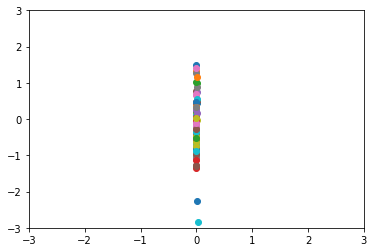

In [67]:
for X_hat in X_hats:
    plt.figure()
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    for i in range(X_hat.shape[0]):
        plt.scatter(X_hat[i],y[i])

In [ ]:
for X_hat in X_hats:
    print(np.linalg.norm(X_hat-X,2))